In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64

In [3]:
import numba

In [4]:
sns.set_context('notebook', font_scale=1.5)

# Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

### Functions to optimize

In [5]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

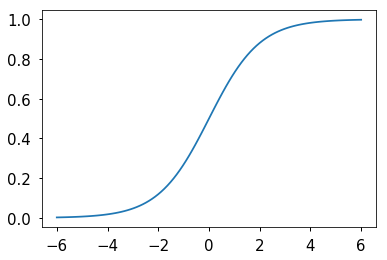

In [6]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

### Data set for classification

In [7]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

### Using gradient descent for classification by logistic regression

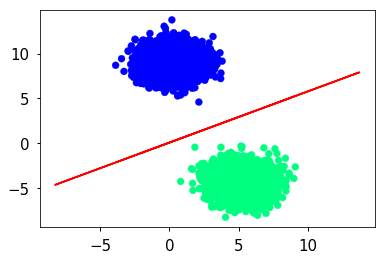

In [8]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [9]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [10]:
def logistic2(x):
    """Logistic function."""
    return 1-1/(1+np.exp(x))

In [11]:
logistic(x),logistic2(x)

(array([0.25244196, 0.73053634, 0.57027629, ..., 0.37094977, 0.52119368,
        0.71561529]),
 array([0.25244196, 0.73053634, 0.57027629, ..., 0.37094977, 0.52119368,
        0.71561529]))

In [12]:
%timeit -r1 -n1 logistic(x)

503 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
%timeit -r1 -n1 logistic2(x)

310 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

### 2.1

Use the @vectorize decorator to create a ufunc version of the logistic function and call this logistic_numba_cpu with function signatures of float64(float64). Create another function called logistic_numba_parallel by giving an extra argument to the decorator of target=parallel (5 points)

In [14]:
from numba import int32, int64, float32, float64

In [15]:
@numba.vectorize([float64(float64)],target='cpu')
def logistic_numba_cpu(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

In [16]:
@numba.vectorize([float64(float64)],target='parallel')
def logistic_numba_parallel(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

### 2.2

For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)

In [17]:
x

array([-1.0856306 ,  0.99734545,  0.2829785 , ..., -0.52814446,
        0.08482555,  0.9228148 ])

In [18]:
np.testing.assert_array_almost_equal(logistic(x),logistic_numba_cpu(x))

In [19]:
np.testing.assert_array_almost_equal(logistic(x),logistic_numba_parallel(x))

In [20]:
%timeit -r1 -n1 logistic(x)

488 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
%timeit -r1 -n1 logistic_numba_cpu(x)

244 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
%timeit -r1 -n1 logistic_numba_parallel(x)

52.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 2.3

Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)

In [23]:
@jit(nopython=True, cache=True)
def logistic_numba(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

In [24]:
@jit(nopython=True, cache=True)
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

In [25]:
%timeit -r1 -n1 logistic(x)

507 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [26]:
%timeit -r1 -n1 logistic_numba(x)

250 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [27]:
X=x.reshape(1000000,10)
y=np.random.random(1000000).reshape(-1,1)
beta=np.random.random(10).reshape(10,-1)
alpha=2
niter=100

In [28]:
%timeit -r1 -n1 gd_numba(X=X, y=y, beta=beta, alpha=2, niter=10)

579 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [29]:
%timeit -r1 -n1 gd(X=X, y=y, beta=beta, alpha=2, niter=10)

723 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 2.4

Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [30]:
gd_numba(X=X, y=y, beta=beta, alpha=2, niter=10)

array([[ 0.00247561],
       [-0.00214145],
       [-0.00220253],
       [ 0.00011847],
       [ 0.00088666],
       [-0.00059415],
       [-0.00151174],
       [-0.00163063],
       [ 0.00023317],
       [-0.00255958]])

In [31]:
gd(X=X, y=y, beta=beta, alpha=2, niter=10)

array([[ 0.00247561],
       [-0.00214146],
       [-0.00220253],
       [ 0.00011847],
       [ 0.00088666],
       [-0.00059415],
       [-0.00151174],
       [-0.00163064],
       [ 0.00023316],
       [-0.00255958]])

In [32]:
np.testing.assert_array_almost_equal(gd(X=X, y=y, beta=beta, alpha=2, niter=10),gd_numba(X=X, y=y, beta=beta, alpha=2, niter=10))

In [33]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

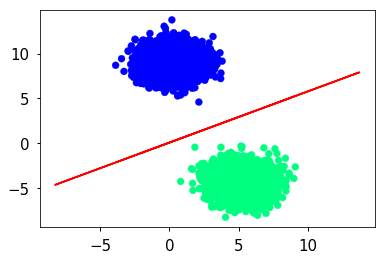

In [34]:
# initial parameters
niter = 1000
a = 0.01
b = np.zeros(p+1)

# call gradient descent
b = gd_numba(X, y, b, a, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ b)
labels = y_pred > 0.5

# calculate separating plane
sep = (-b[0] - b[1] * X)/b[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [35]:
len(x)

10000000

In [36]:
%%cython -a

cimport cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def logistic_cython(double[:] x):
    """Logistic function."""
    cdef int i
    cdef int n = x.shape[0]
    cdef double [:] res = np.zeros(n)
    for i in range(n):
        res[i] = 1.0-1.0/(1.0+np.exp(x[i]))
    return res

In [37]:
logistic_cython(x)

<MemoryView of 'ndarray' at 0x7fbdddfae890>

In [38]:
np.testing.assert_array_almost_equal(logistic(x), logistic_cython(x))

In [39]:
%timeit logistic2(x)

310 ms ± 4.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit logistic_cython(x)

11.7 s ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%cython --annotate

import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef logistic_c(double[:] x):
    """Logistic function."""
    cdef int i
    cdef int n = x.shape[0]
    cdef double [:] res = np.zeros(n)
    for i in range(n):
        res[i] = 1.0-1.0/(1.0+np.exp(x[i]))
    return res

def gd_cython(double[:,:] X, double[:] y, double[:] beta, double alpha, int niter):
    """Gradient descent algorihtm."""    
    cdef int n = X.shape[0]
    cdef int p = X.shape[1]
    cdef double[:] eps = np.zeros(n)
    cdef double[:] y_pred = np.zeros(n)
    cdef double[:] grad = np.zeros(p)  
    cdef int i, j, k
    cdef double[:, :] Xt = X.T
    for i in range(niter):
        y_pred = logistic_c(np.dot(X, beta))
        for j in range(n):
            eps[j] = y[j] - y_pred[j]
        grad = np.dot(Xt, eps) / n
        for k in range(p):
            beta[k] += alpha * grad[k]
    return beta

In [42]:
X=x.reshape(1000000,10)
y=np.random.random(1000000)
beta=np.random.random(10)
alpha=2
niter=100

In [50]:
gd_cython(X, y, beta, alpha, niter)

<MemoryView of 'ndarray' at 0x7fbdddf8c048>

In [49]:
gd(X, y, beta, alpha, niter)

array([ 6.19638653e-04, -1.45782639e-03, -1.10640293e-05,  1.78513829e-04,
       -6.27646547e-04,  3.13713773e-03,  6.10561219e-04, -1.85235831e-05,
        1.05119006e-03,  5.96215448e-04])

In [51]:
np.testing.assert_almost_equal(gd(X, y, beta, alpha, niter),gd_cython(X, y, beta, alpha, niter))

In [52]:
%timeit gd(X, y, beta, alpha, niter)

6.82 s ± 74.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


sorry I once got the results, however, I restarted the notebook and reran this code, it took too long to run. I have to stop it.

In [ ]:
%timeit gd_cython(X, y, beta, alpha, niter)

**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations (include path is `../notebooks/eigen3`)
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help

In [36]:
import cppimport

In [37]:
%%file codes.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['./eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/eigen.h>

namespace py = pybind11;

Eigen::VectorXd logistic(Eigen::VectorXd x) {
    return  1.0-1.0/(1.0+exp(x.array())) ;
}

Eigen::VectorXd gd(Eigen::MatrixXd X, Eigen::VectorXd y, Eigen::VectorXd beta, double alpha, int niter) {
    int n = X.rows();    
    Eigen::VectorXd y_pred;
    Eigen::VectorXd esp;
    Eigen::VectorXd grad;
    Eigen::MatrixXd Xt = X.transpose();            
    for (int i=0; i<niter; i++) {
        y_pred = logistic(X * beta);
        esp = y - y_pred;
        grad = Xt * esp / n;
        beta = beta + alpha * grad;}
    return beta;
}

PYBIND11_PLUGIN(codes) {
    py::module m("codes", "pybind11 example plugin");
    m.def("logistic", &logistic, "The logistic fucntion.");
    m.def("gd", &gd, "The gradient descent fucntion.");
    return m.ptr();
}

Overwriting codes.cpp


In [38]:
cppimport.force_rebuild() 
funcs = cppimport.imp("codes")

In [39]:
np.testing.assert_array_almost_equal(logistic(x), funcs.logistic(x))

In [40]:
%timeit logistic(x)

495 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit funcs.logistic(x)

147 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
X=x.reshape(1000000,10)
y=np.random.random(1000000)
beta=np.random.random(10)
alpha=2
niter=100

In [43]:
np.testing.assert_array_almost_equal(gd(X, y, beta, alpha, niter), funcs.gd(X, y, beta, alpha, niter))

In [44]:
%timeit gd(X, y, beta, alpha, niter)

6.91 s ± 65.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit funcs.gd(X, y, beta, alpha, niter)

2.96 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
